In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import coffea.util as util
import time
import json
import os
import copy
from hist import Hist
sys.path.append("../../analysisTools/")
import plotTools as ptools
import utils
import mplhep as hep
import utils
hep.style.use("CMS")
plt.rcParams['font.size'] = 16.0
from matplotlib.colors import Normalize, LogNorm
from copy import deepcopy
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
hcb = ptools.histContainer("bkg_2018_triggerStudy.coffea")
hcs = ptools.histContainer("signal_2018_triggerStudy.coffea")
hcd = ptools.histContainer("data_2018_EGamma_triggerStudy.coffea")

def get_eff(h):
    num = h[{'passMET':1}]
    bins = num.axes[0].edges
    num = num.values()
    den = h[{'passMET':sum}].values()
    eff = np.divide(num,den,where=den!=0,out=np.zeros_like(num))
    eff_uncert = eff * (np.divide(1,num,where=num!=0,out=np.zeros_like(num)) +\
                                np.divide(1,den,where=den!=0,out=np.zeros_like(den)))
    return eff, eff_uncert, bins

def get_eff_v2(h,refName):
    num = h[{'refTrig':refName,'passMET':1,'passRef':1}]
    bins = num.axes[0].edges
    num = num.values()
    den = h[{'refTrig':refName,'passMET':sum,'passRef':1}].values()
    eff = np.divide(num,den,where=den!=0,out=np.zeros_like(num))
    eff_uncert = eff * (np.divide(1,num,where=num!=0,out=np.zeros_like(num)) +\
                                np.divide(1,den,where=den!=0,out=np.zeros_like(den)))
    return eff, eff_uncert, bins


In [22]:
rebin = 20j
hs = hcs.load("MET_passTrig_refTrig")[{"samp":sum}][:,::rebin,:,:]
hb = hcb.load("MET_passTrig_refTrig")[{"samp":sum}][:,::rebin,:,:]
hd = hcd.load("MET_passTrig_refTrig")[{"samp":sum}][:,::rebin,:,:]

In [23]:
hcs.hnames

['MET_passTrig',
 'MET_all',
 'MET_passTrig_all',
 'jet_pt_all',
 'jet_pt_passTrig',
 'MET_passTrig_refTrig']

In [24]:
trigs_sig = set([hs.axes[0].value(i) for i in range(hs.axes[0].size)])
trigs_bkg = set([hb.axes[0].value(i) for i in range(hb.axes[0].size)])
trigs_data = set([hd.axes[0].value(i) for i in range(hd.axes[0].size)])
avail = trigs_sig & trigs_bkg & trigs_data
print("\n".join(list(avail)))

HLT_Ele28_eta2p1_WPTight_Gsf_HT150
HLT_Ele32_WPTight_Gsf_L1DoubleEG
HLT_Ele23_CaloIdM_TrackIdM_PFJet30
HLT_Ele35_WPTight_Gsf
HLT_Ele32_WPTight_Gsf
HLT_DoubleEle8_CaloIdM_TrackIdM_Mass8_DZ_PFHT350
HLT_Ele16_Ele12_Ele8_CaloIdL_TrackIdL
HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
HLT_DoubleEle24_eta2p1_WPTight_Gsf
HLT_DoubleEle8_CaloIdM_TrackIdM_Mass8_PFHT350
HLT_Ele35_WPTight_Gsf_L1EGMT
HLT_Ele30_eta2p1_WPTight_Gsf_CentralPFJet35_EleCleaned
HLT_Ele12_CaloIdL_TrackIdL_IsoVL_PFJet30
HLT_Ele8_CaloIdL_TrackIdL_IsoVL_PFJet30
HLT_DoubleEle33_CaloIdL_MW
HLT_Ele38_WPTight_Gsf
HLT_DoubleEle27_CaloIdL_MW
HLT_Ele17_CaloIdM_TrackIdM_PFJet30
HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL
HLT_Ele8_CaloIdM_TrackIdM_PFJet30
HLT_Ele40_WPTight_Gsf


In [25]:
for refTrig in avail:
    sig_eff,sig_eff_uncert,bins = get_eff_v2(hs,refTrig)
    bkg_eff,bkg_eff_uncert,bins = get_eff_v2(hb,refTrig)
    data_eff,data_eff_uncert,bins = get_eff_v2(hd,refTrig)
    
    fig,axes = plt.subplots(2,1,height_ratios=[3.5,1],sharex=True,figsize=(8,8))
    plt.sca(axes[0])
    hep.histplot([data_eff,bkg_eff],color=['k','red'],bins=bins,
                 yerr=[data_eff_uncert,bkg_eff_uncert],histtype='errorbar')
    hep.histplot([data_eff,bkg_eff],color=['k','red'],bins=bins,
                 yerr=[data_eff_uncert,bkg_eff_uncert],label=['Data','Bkg MC'],histtype='step')
    plt.ylim([0,1.1])
    plt.axhline(1,linestyle='--',color='gray',lw=2)
    plt.legend(loc=(0.4,0.6),fontsize=20)
    hep.cms.text("Preliminary")
    plt.ylabel("Efficiency")
    plt.sca(axes[1])
    hep.histplot(data_eff/bkg_eff,bins=bins,histtype='errorbar',yerr=False,color='k')
    plt.ylabel("Data/MC")
    plt.ylim([0,2])
    plt.axhline(1,color='k',linestyle='--',)
    plt.xlabel(r"$p_T^\mathrm{miss}$ [GeV]")
    plt.grid(which='both',axis='both')

    plt.savefig(f"turnOnCurves/dataVsBkg_METnoMu120_{refTrig}.pdf")
    plt.close()
    
    ########
    
    # with sig MC
    fig,axes = plt.subplots(2,1,height_ratios=[3.5,1],sharex=True,figsize=(8,8))
    plt.sca(axes[0])
    hep.histplot([data_eff,sig_eff],color=['k','blue'],bins=bins,
                 yerr=[data_eff_uncert,sig_eff_uncert],histtype='errorbar')
    hep.histplot([data_eff,sig_eff],color=['k','blue'],bins=bins,
                 yerr=[data_eff_uncert,sig_eff_uncert],label=['Data','Signal MC'],histtype='step')
    plt.ylim([0,1.1])
    plt.axhline(1,linestyle='--',color='gray',lw=2)
    plt.legend(loc=(0.4,0.6),fontsize=20)
    hep.cms.text("Preliminary")
    plt.ylabel("Efficiency")
    plt.sca(axes[1])
    hep.histplot(np.divide(data_eff,sig_eff,where=sig_eff>0,out=np.full_like(data_eff,np.nan)),bins=bins,histtype='errorbar',yerr=False,color='k')
    plt.ylabel("Data/MC")
    plt.ylim([0,2])
    plt.axhline(1,color='k',linestyle='--',)
    plt.xlabel(r"$p_T^\mathrm{miss}$ [GeV]")
    plt.grid(which='both',axis='both')

    plt.savefig(f"turnOnCurves/dataVsSig_METnoMu120_{refTrig}.pdf")
    plt.close()

/opt/conda/lib/python3.10/site-packages/hist/basehist.py:417: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


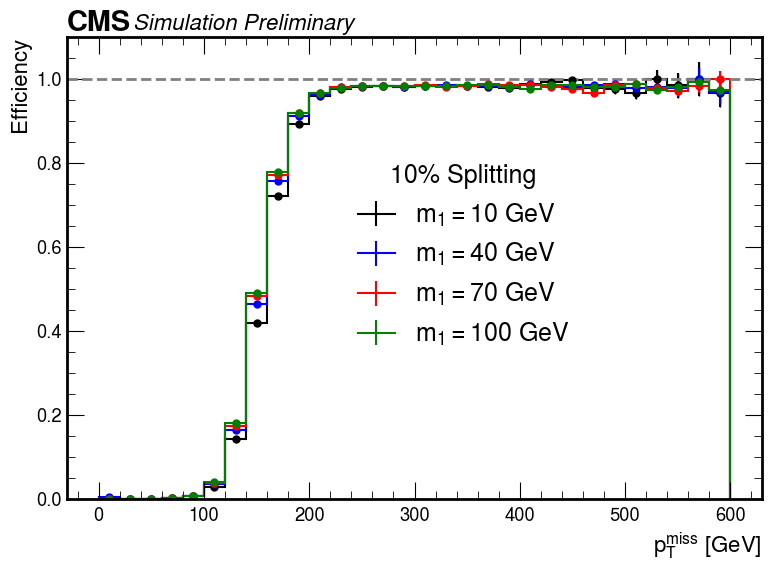

In [26]:
# sig only
samps_d10 = [["sig_2018_Mchi-10p5_dMchi-1p0_ctau-1","sig_2018_Mchi-10p5_dMchi-1p0_ctau-10","sig_2018_Mchi-10p5_dMchi-1p0_ctau-100"],
             ["sig_2018_Mchi-42p0_dMchi-4p0_ctau-1","sig_2018_Mchi-42p0_dMchi-4p0_ctau-10","sig_2018_Mchi-42p0_dMchi-4p0_ctau-100"],
             ["sig_2018_Mchi-73p5_dMchi-7p0_ctau-1","sig_2018_Mchi-73p5_dMchi-7p0_ctau-10","sig_2018_Mchi-73p5_dMchi-7p0_ctau-100"],
             ["sig_2018_Mchi-105p0_dMchi-10p0_ctau-1","sig_2018_Mchi-105p0_dMchi-10p0_ctau-10","sig_2018_Mchi-105p0_dMchi-10p0_ctau-100"]]
colors = ['k','b','r','green']
labels = [r"$m_1 = 10$ GeV",r"$m_1 = 40$ GeV",r"$m_1 = 70$ GeV",r"$m_1 = 100$ GeV"]
sig_effs = []
sig_uncerts = []
for samps in samps_d10:
    refTrig = "HLT_Ele38_WPTight_Gsf"
    hs = hcs.load("MET_passTrig_refTrig")[{"samp":samps,"refTrig":refTrig,"passRef":sum}]
    hs = hs[{"samp":sum}][::rebin,:]
    sig_eff,sig_eff_uncert,bins = get_eff(hs)
    sig_effs.append(sig_eff)
    sig_uncerts.append(sig_eff_uncert)

#fig,axes = plt.subplots(2,1,height_ratios=[3.5,1],sharex=True,figsize=(8,8))
plt.figure(figsize=(8,6))
hep.histplot(sig_effs,color=colors,bins=bins,
             yerr=sig_uncerts,histtype='errorbar')
hep.histplot(sig_effs,color=colors,bins=bins,
             yerr=sig_uncerts,label=labels,histtype='step')
plt.ylim([0,1.1])
plt.axhline(1,linestyle='--',color='gray',lw=2)
plt.legend(loc=(0.4,0.3),fontsize=18,title="10% Splitting",title_fontsize=18)
hep.cms.text("Simulation Preliminary")
plt.ylabel("Efficiency")
plt.xlabel(r"$p_T^\mathrm{miss}$ [GeV]")
plt.tight_layout()
plt.savefig(f"turnOnCurves/sig_turnOns_METnoMu120_delta10.pdf")
#plt.close()

/opt/conda/lib/python3.10/site-packages/hist/basehist.py:417: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


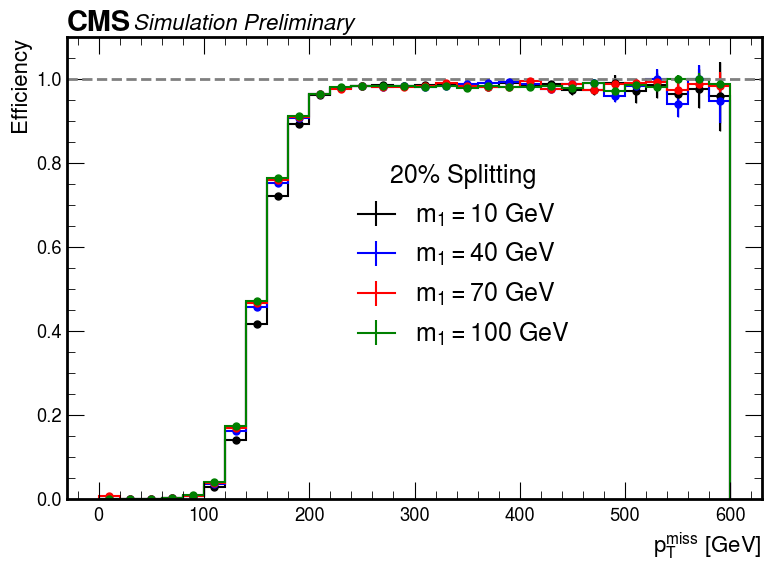

In [27]:
# sig only
samps_d20 = [["sig_2018_Mchi-11p0_dMchi-2p0_ctau-1","sig_2018_Mchi-11p0_dMchi-2p0_ctau-10","sig_2018_Mchi-11p0_dMchi-2p0_ctau-100"],
             ["sig_2018_Mchi-44p0_dMchi-8p0_ctau-1","sig_2018_Mchi-44p0_dMchi-8p0_ctau-10","sig_2018_Mchi-44p0_dMchi-8p0_ctau-100"],
             ["sig_2018_Mchi-77p0_dMchi-14p0_ctau-1","sig_2018_Mchi-77p0_dMchi-14p0_ctau-10","sig_2018_Mchi-77p0_dMchi-14p0_ctau-100"],
             ["sig_2018_Mchi-110p0_dMchi-20p0_ctau-1","sig_2018_Mchi-110p0_dMchi-20p0_ctau-10","sig_2018_Mchi-110p0_dMchi-20p0_ctau-100"]]
colors = ['k','b','r','green']
labels = [r"$m_1 = 10$ GeV",r"$m_1 = 40$ GeV",r"$m_1 = 70$ GeV",r"$m_1 = 100$ GeV"]
sig_effs = []
sig_uncerts = []
for samps in samps_d20:
    refTrig = "HLT_Ele38_WPTight_Gsf"
    hs = hcs.load("MET_passTrig_refTrig")[{"samp":samps,"refTrig":refTrig,"passRef":sum}]
    hs = hs[{"samp":sum}][::rebin,:]
    sig_eff,sig_eff_uncert,bins = get_eff(hs)
    sig_effs.append(sig_eff)
    sig_uncerts.append(sig_eff_uncert)

#fig,axes = plt.subplots(2,1,height_ratios=[3.5,1],sharex=True,figsize=(8,8))
plt.figure(figsize=(8,6))
hep.histplot(sig_effs,color=colors,bins=bins,
             yerr=sig_uncerts,histtype='errorbar')
hep.histplot(sig_effs,color=colors,bins=bins,
             yerr=sig_uncerts,label=labels,histtype='step')
plt.ylim([0,1.1])
plt.axhline(1,linestyle='--',color='gray',lw=2)
plt.legend(loc=(0.4,0.3),fontsize=18,title="20% Splitting",title_fontsize=18)
hep.cms.text("Simulation Preliminary")
plt.ylabel("Efficiency")
plt.xlabel(r"$p_T^\mathrm{miss}$ [GeV]")
plt.tight_layout()
plt.savefig(f"turnOnCurves/sig_turnOns_METnoMu120_delta20.pdf")
#plt.close()